In [1]:
import pandas as pd
import os
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from IPython.display import display_html
import warnings
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

from sklearn.utils import validation as skval
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # default='warn'

/Users/timothyteh/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
%%time
books_metadata = pd.read_json('./datasets/goodreads_books_poetry.json', lines=True)
interactions = pd.read_json('./datasets/goodreads_interactions_poetry.json', lines=True)

CPU times: user 44.1 s, sys: 41.8 s, total: 1min 25s
Wall time: 1min 47s


### EDA for Books Metadata

In [3]:
books_metadata.columns.values

array(['isbn', 'text_reviews_count', 'series', 'country_code',
       'language_code', 'popular_shelves', 'asin', 'is_ebook',
       'average_rating', 'kindle_asin', 'similar_books', 'description',
       'format', 'link', 'authors', 'publisher', 'num_pages',
       'publication_day', 'isbn13', 'publication_month',
       'edition_information', 'publication_year', 'url', 'image_url',
       'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'], dtype=object)

In [4]:
books_metadata.sample(2)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
21102,0140430067,9,[],US,eng,"[{'count': '136', 'name': 'to-read'}, {'count'...",,false,3.92,,...,,,,https://www.goodreads.com/book/show/935013.Thr...,https://s.gr-assets.com/assets/nophoto/book/11...,935013,114,919997,Three Jacobean Tragedies: The White Devil; The...,Three Jacobean Tragedies: The White Devil; The...
10002,1932870008,1,[],US,,"[{'count': '2', 'name': 'poetry'}]",,false,3.75,,...,,,,https://www.goodreads.com/book/show/1772402.Ha...,https://s.gr-assets.com/assets/nophoto/book/11...,1772402,4,1770565,Half Lives: Petrarchan Poems,Half Lives: Petrarchan Poems


In [5]:
books_metadata.shape

(36514, 29)

### Data Preprocessing for Books Metadata

In [6]:
# Limit the books metadata to selected fields
books_metadata_selected = books_metadata[['book_id', 'average_rating', 'is_ebook', 'num_pages', 
                                          'publication_year', 'ratings_count', 'language_code']]
books_metadata_selected.sample(10)

,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
14477,30631518,3.63,false,232,2016,51,spa
1561,1530853,4.83,false,,2007,11,
27087,6979903,4.56,false,24,2009,9,eng
24264,27163855,4.60,false,74,2015,5,
12816,16057339,4.25,false,156,2013,449,eng
11284,6764121,4.16,false,197,1964,1,eng
1767,153356,4.15,false,120,2002,76,
11668,20661453,2.88,true,,,40,
27762,20613520,4.32,false,224,2014,40,
18891,7858300,4.02,false,208,2010,50,


In [7]:
### Preprocessing of Books_Metadata

# replace blank cells with NaN
books_metadata_selected.replace('', np.nan, inplace=True)

# replace nan values in 'num_pages' to -1
books_metadata_selected['num_pages'].replace(np.nan, -1, inplace=True)

# convery values in 'num_pages' to numeric values
books_metadata_selected['num_pages'] = pd.to_numeric(books_metadata_selected['num_pages'])

# using pandas cut method to convert fields into discrete intervals
books_metadata_selected['num_pages'] = pd.cut(books_metadata_selected['num_pages'], bins=25)

# rounding ratings to neares .5 score
books_metadata_selected['average_rating'] = books_metadata_selected['average_rating'].apply(lambda x: round(x*2)/2)

# using pandas qcut method to convert fields into quantile-based discrete intervals
books_metadata_selected['ratings_count'] = pd.qcut(books_metadata_selected['ratings_count'], 25)

# replacing missing values to year 2100
books_metadata_selected['publication_year'].replace(np.nan, 2100, inplace=True)

# replacing missing values to 'unknown'
books_metadata_selected['language_code'].replace(np.nan, 'unknown', inplace=True)

# convert is_ebook column into 1/0 where true=1 and false=0
books_metadata_selected['is_ebook'] = books_metadata_selected.is_ebook.map(lambda x: 1.0*(x == 'true'))

# keep only english books
books_metadata_selected = books_metadata_selected.loc[books_metadata_selected['language_code'] == 'eng']

# print results
books_metadata_selected.sample(10)

,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
5834,267760,4.0,0.0,"(437.44, 875.88]",1994,"(73.0, 94.0]",eng
13786,25497800,3.0,0.0,"(-11.961, 437.44]",2015,"(-0.001, 2.0]",eng
13494,1258941,4.0,0.0,"(-11.961, 437.44]",2002,"(5.0, 7.0]",eng
12368,2864310,4.0,0.0,"(-11.961, 437.44]",1977,"(10.0, 12.0]",eng
4547,13588404,4.0,0.0,"(-11.961, 437.44]",2012,"(614.0, 1029527.0]",eng
13302,150253,4.5,0.0,"(-11.961, 437.44]",2003,"(614.0, 1029527.0]",eng
204,4361538,4.5,0.0,"(-11.961, 437.44]",1998,"(2.0, 3.0]",eng
14587,18906488,4.0,0.0,"(-11.961, 437.44]",2014,"(10.0, 12.0]",eng
35775,23433203,4.5,0.0,"(-11.961, 437.44]",2014,"(12.0, 14.0]",eng
13966,86922,4.0,0.0,"(-11.961, 437.44]",2100,"(179.0, 285.0]",eng


In [8]:
books_metadata_selected.shape

(8393, 7)

### EDA for Interactions data

In [9]:
interactions.columns.values

array(['user_id', 'book_id', 'review_id', 'is_read', 'rating',
       'review_text_incomplete', 'date_added', 'date_updated', 'read_at',
       'started_at'], dtype=object)

In [10]:
interactions.sample(5)

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
476169,e669346e31e35a2947fa7844486b9262,8138906,00d3edf90de934fb929b2a5c6f4a2140,False,0,,Sun Oct 27 15:05:06 -0700 2013,Sun Oct 27 15:05:06 -0700 2013,,
2216158,c3a18d886abe4b68139105dc9e6d7de1,1609396,9968dbcef90997fd8a360dcc66dd0dae,False,0,,Tue Dec 08 22:44:53 -0800 2015,Tue Dec 08 22:44:53 -0800 2015,,
202800,fd78163934bd87fa6d81158f85a0cd71,2073853,959813e8ce37f79add066bf72fdf0f66,True,5,,Tue Sep 25 06:36:00 -0700 2012,Tue Jan 21 09:47:45 -0800 2014,Tue Jan 21 09:47:45 -0800 2014,Tue Jan 21 09:47:42 -0800 2014
569991,46084d80ffe7a7a7ec91f0ad2a8d96d1,618944,f8830b664b91ad6e7beb566d30556c38,True,5,,Tue Mar 19 09:12:35 -0700 2013,Mon Feb 16 16:54:41 -0800 2015,,
2344793,6ac836310f327c789cdf6256c99277bf,6092946,14c73d4866aa442c145cea44488a6e6c,False,0,,Mon Oct 05 09:58:16 -0700 2015,Mon Oct 05 09:58:18 -0700 2015,,


In [11]:
interactions.shape

(2734350, 10)

### Data Preprocessing for Interactions data

In [12]:
# Limit the books metadata to selected fields
interactions_selected = interactions[['user_id', 'book_id', 'is_read', 'rating']]

# Limit the books to only those in the preprocessed books metadata
english_book_ids = list(books_metadata_selected['book_id'])
interactions_selected = interactions_selected.loc[interactions_selected['book_id'].isin(english_book_ids)]

# # mapping boolean to string
booleanDictionary = {True: 'true', False: 'false'}
interactions_selected['is_read'] = interactions_selected['is_read'].replace(booleanDictionary)

# # convert is_read column into 1/0 where true=1 and false=0
interactions_selected['is_read'] = interactions_selected.is_read.map(
    lambda x: 1.0*(x == 'true'))

interactions_selected

,user_id,book_id,is_read,rating
0,8842281e1d1347389f2ab93d60773d4d,1384,1.0,4
1,8842281e1d1347389f2ab93d60773d4d,1376,1.0,4
2,8842281e1d1347389f2ab93d60773d4d,30119,1.0,5
3,72fb0d0087d28c832f15776b0d936598,24769928,0.0,0
4,72fb0d0087d28c832f15776b0d936598,30119,1.0,3
...,...,...,...,...
2734321,bfc558b791304f0ce74ad1c3a6ab08f7,1381,1.0,5
2734322,e9aea57d21cdf9d91a65687d59518924,25144676,0.0,0
2734323,e9aea57d21cdf9d91a65687d59518924,25330489,0.0,0
2734339,148e49f7ed14137ff13a9a31c770487d,291,0.0,0


In [13]:
# how many data points are there where the user hasn't read the book but have given the ratings.
interactions_selected.groupby(['rating', 'is_read']).size().reset_index().pivot(columns='rating', index='is_read', values=0)

rating,0,1,2,3,4,5
is_read,,,,,,
0.0,685408.0,NaN,NaN,NaN,NaN,NaN
1.0,37226.0,9416.0,30095.0,118069.0,207232.0,265438.0


In [14]:
# drop interactions where is_read is false, and limit interactions from random 5000 users to limit the data size for further analysis
interactions_selected2 = interactions_selected.loc[interactions_selected['is_read']==1, ['user_id', 'book_id', 'rating']]

interactions_selected2 = interactions_selected2[interactions_selected2['user_id'].isin(random.sample(list(interactions_selected2['user_id'].unique()), 
                                                                                                  k=5000))]

interactions_selected2.sample(10)

,user_id,book_id,rating
300913,5f79262744dcb1b96d5fd83f845fde8e,1381,3
166095,f0f2cc52434fb415674480d9bb5dc94a,1420,5
1119150,911b7a480be06788d570e4a85486d131,119079,5
405452,53b04b3da7b14c19d2324cfaa3906796,21932950,3
1250151,17f4067b143e816b7ad3d5af15369859,3348584,4
2657298,5b1c4322e91836a0da572863a2eaef0d,1420,5
797933,83d11cd067da6629f82510f949625e38,12914,3
2594275,dccc7b6ecbe2ac5794e80f20e2815168,118252,3
1961382,054cb8dec88acc15db27c1b7e9f95196,29491487,4
1595372,3ddff5d2a8d28e9be0841e9737bb6737,4787999,4


In [15]:
interactions_selected2.shape

(15243, 3)

In [16]:
# computer average number of interactions per user
list_of_all_users_who_rated = list(interactions_selected2['user_id'])
interaction_dict = {}
for user in list_of_all_users_who_rated:
    if user not in interaction_dict.keys():
        interaction_dict[user] = 1
    else:
        interaction_dict[user] += 1
average_interactions_per_user = sum(interaction_dict.values()) / len(interaction_dict)
print("Average interactions per user: {}".format(average_interactions_per_user))

Average interactions per user: 3.0486


In [17]:
relevant_book_ids = interactions_selected2['book_id'].unique()
relevant_book_ids

array([    1381,    30119, 30075802, ...,  8381810, 21891971, 13592242])

### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Interactions data

In [18]:
user_book_interaction = pd.pivot_table(interactions_selected2, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)

user_book_interaction.head(10)

book_id,244,290,291,292,484,676,1371,1372,1376,1381,...,35612585,35663570,35671033,35820905,35905478,36126998,36130073,36274645,36390042,36417323
user_id,,,,,,,,,,,,,,,,,,,,,
0012a2d9f76156d17aafc21c33dec83b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019b485b2e71132a2cc6059cad87f26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019e891665331a2d57eceda5f73cc43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00221b8ff651d375a5b066d2ff6c98da,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028a318edd10f4f3b218ad4a230102d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005bbacfe0299839508276070e464776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005d3d8ca7110191403ee6f86e594305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00809f14dfb891485d459c63b6f2f73e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0081571f69259ed4bf3ecd67ac4168a8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
len(user_book_interaction.index)

5000

In [20]:
user_book_interaction_csr = csr_matrix(user_book_interaction.values)

In [21]:
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

### Data Preprocessing: Conversion to Compressed Sparse Row (CSR) Matrix for Books Metadata

In [22]:
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
    
relevant_item_dict = {}
for i in relevant_book_ids:
    relevant_item_dict[i] = item_dict[i]


In [23]:
# dummify categorical features
books_metadata_selected_transformed = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 'num_pages', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])

books_metadata_selected_transformed = books_metadata_selected_transformed.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed = books_metadata_selected_transformed.loc[books_metadata_selected_transformed["book_id"].isin(relevant_item_dict)].set_index("book_id")
# books_metadata_selected_transformed = books_metadata_selected_transformed.transpose()
books_metadata_selected_transformed.head(5)

,average_rating_0.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,is_ebook_0.0,...,"ratings_count_(40.0, 49.0]","ratings_count_(49.0, 59.0]","ratings_count_(59.0, 73.0]","ratings_count_(73.0, 94.0]","ratings_count_(94.0, 125.0]","ratings_count_(125.0, 179.0]","ratings_count_(179.0, 285.0]","ratings_count_(285.0, 614.0]","ratings_count_(614.0, 1029527.0]",language_code_eng
book_id,,,,,,,,,,,,,,,,,,,,,
244,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
290,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
291,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
292,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
484,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [24]:
books_metadata_selected_transformed.shape

(2122, 211)

In [25]:
# convert to csr matrix
# books_metadata_csr = csr_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_csr = csr_matrix(books_metadata_selected_transformed.values)
books_metadata_csr

<2122x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 12732 stored elements in Compressed Sparse Row format>

In [26]:
# books_metadata_coo = coo_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_coo = coo_matrix(books_metadata_selected_transformed.values)
books_metadata_coo

<2122x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 12732 stored elements in COOrdinate format>

### Hyperparameter Tuning

In [27]:
train_interactions, test_interactions = random_train_test_split(user_book_interaction_csr, test_percentage=0.2)
train_interactions

<5000x2122 sparse matrix of type '<class 'numpy.float64'>'
	with 11537 stored elements in COOrdinate format>

In [28]:
test_interactions

<5000x2122 sparse matrix of type '<class 'numpy.float64'>'
	with 2885 stored elements in COOrdinate format>

In [29]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [30]:
num_samples_for_random_search = 10

In [31]:
def random_search_auc(train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = auc_score(model, validation, train_interactions=train2, item_features = item_features, num_threads=num_threads).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)

In [32]:
### Best hyperparameters to maximise AUC score
(score_auc, hyperparams_auc, model) = max(random_search_auc(train=train_interactions, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])

print("Best AUC score {} \nHyperparameters: \n{}".format(score_auc, hyperparams_auc))

Best AUC score 0.8818134069442749 
Hyperparameters: 
{'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01578404799775174, 'item_alpha': 1.2978987251459544e-08, 'user_alpha': 1.0002277375254094e-08, 'max_sampled': 14, 'num_epochs': 5}


In [33]:
train2, validation = random_train_test_split(train_interactions, test_percentage=0.2)
train2

<5000x2122 sparse matrix of type '<class 'numpy.float64'>'
	with 9229 stored elements in COOrdinate format>

In [34]:
validation

<5000x2122 sparse matrix of type '<class 'numpy.float64'>'
	with 2308 stored elements in COOrdinate format>

In [35]:
def random_search_precision_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train2, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = precision_at_k(model, validation, train2, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best precision score at k=1000: 0.00127557257656008
Precision scores at k=1000: [0.0013264916, 0.0007350867, 0.0004934787, 0.00037010905, 0.0002960872]

Best precision score at k=2000: 0.0007100387010723352
Precision scores at k=2000: [0.0013187942, 0.0007363695, 0.0004934787, 0.00037010905, 0.0002960872]

Best precision score at k=3000: 0.0004740626900456846
Precision scores at k=3000: [0.001320077, 0.00073604885, 0.0004934787, 0.00037010905, 0.0002960872]

Best precision score at k=4000: 0.0003630999708548188
Precision scores at k=4000: [0.0011449648, 0.00072097505, 0.0004934787, 0.00037010905, 0.0002960872]

Best precision score at k=5000: 0.00028226294671185315
Precision scores at k=5000: [0.001315587, 0.00073284167, 0.0004934787, 0.00037010905, 0.0002960872]

Best highest average precision: 0.0006442506506573409 
Best k: 1000 
Best hyperparams to maximise precision_at_k score: {'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.00033705355

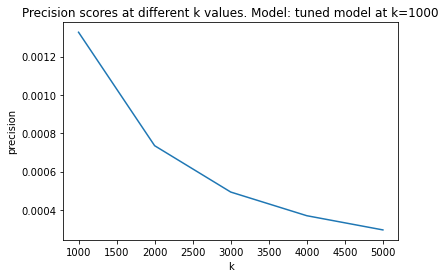

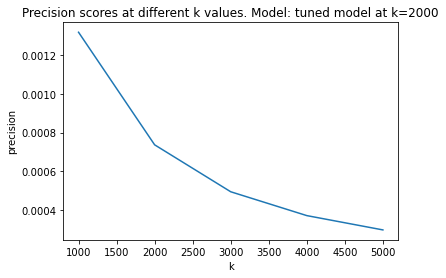

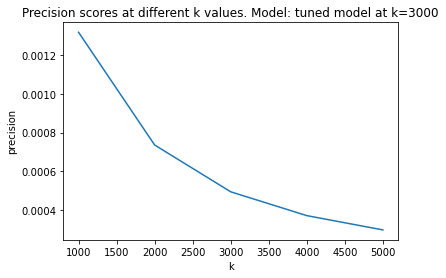

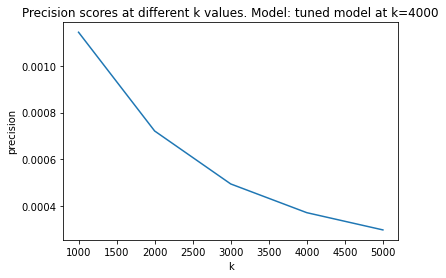

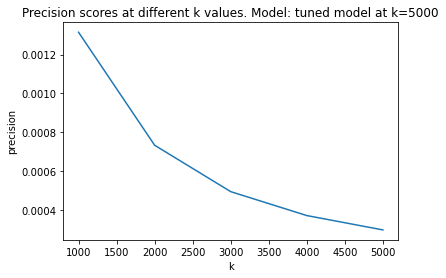

In [36]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 1: large k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1000, 5001, 1000):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1000, 5001, 1000):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1000, 5001,1000), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))


Best precision score at k=1: 0.10347431898117065
Precision scores at k=1: [0.123797305, 0.061898652, 0.041693393, 0.032392558, 0.025914049, 0.021808852, 0.018784937, 0.016436819, 0.014610506]

Best precision score at k=2: 0.0572720430791378
Precision scores at k=2: [0.123797305, 0.061898652, 0.041693393, 0.032392558, 0.026042337, 0.021701947, 0.018693304, 0.016436819, 0.014610506]

Best precision score at k=3: 0.039453718811273575
Precision scores at k=3: [0.123797305, 0.06221937, 0.041479584, 0.031430405, 0.026170624, 0.022129571, 0.019792909, 0.020525979, 0.021452498]

Best precision score at k=4: 0.01727410778403282
Precision scores at k=4: [0.043617703, 0.028864658, 0.02159504, 0.019724183, 0.017447082, 0.016249733, 0.016860625, 0.015795382, 0.015323213]

Best precision score at k=5: 0.0160059854388237
Precision scores at k=5: [0.010904426, 0.012828737, 0.010690615, 0.011545863, 0.017318795, 0.0151806725, 0.01695226, 0.016597178, 0.015750838]

Best precision score at k=6: 0.018156

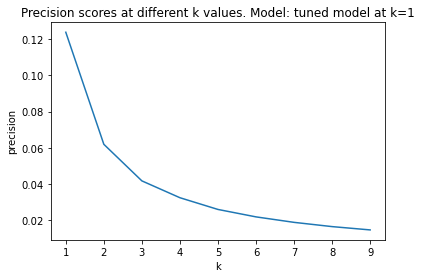

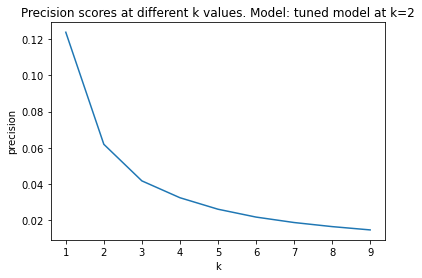

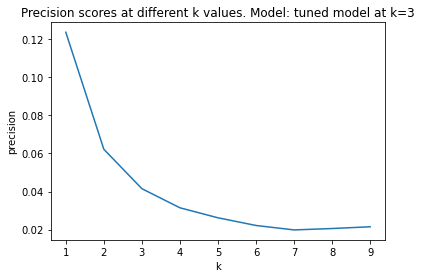

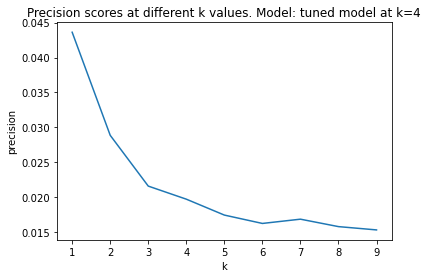

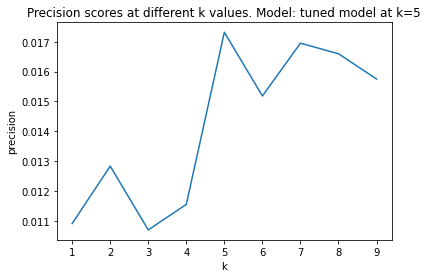

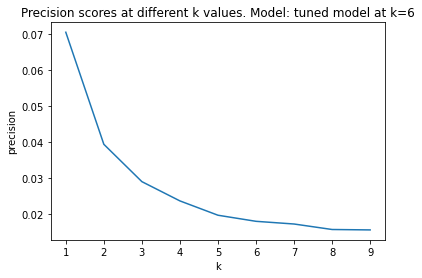

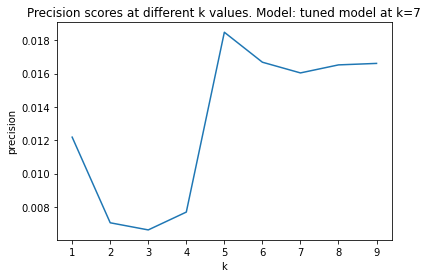

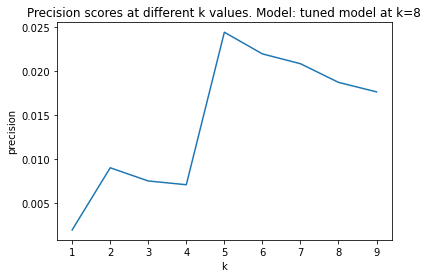

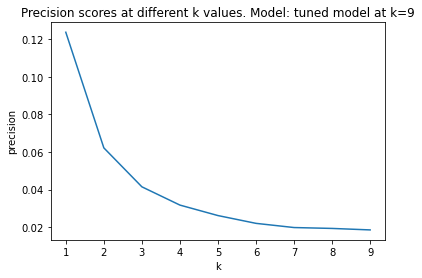

In [37]:
### Best hyperparameters to maximise precision_at_k score

# Experiment 2: low k-values
counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1, 10):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1, 10):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1, 10), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))

In [38]:
def random_search_recall_at_k(k, train, item_features, num_samples=num_samples_for_random_search, num_threads=1, cv=5):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.
    Parameters
    ----------
    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------
    generator of (auc_score, hyperparameter dict, fitted model)
    """
    for i in range(cv):
        train2, validation = random_train_test_split(train, test_percentage=0.2)
        for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
            num_epochs = hyperparams.pop("num_epochs")

            model = LightFM(**hyperparams)
            model.fit(train, epochs=num_epochs,item_features=item_features, num_threads=num_threads)

            score = recall_at_k(model, test_interactions, train_interactions, k=k, item_features=item_features, preserve_rows=False, num_threads=1, check_intersections=True).mean()

            hyperparams["num_epochs"] = num_epochs

            yield (score, hyperparams, model)


Best recall score at k=500: 0.8567722313673731
Recall scores at k=500: [0.8501143456002339, 0.927103968300248, 0.9622129847915608, 0.9964908060722686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1000: 0.9350022339620927
Recall scores at k=1000: [0.8574058763202446, 0.9326018940435233, 0.9688709693841189, 0.9953167476098843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1500: 0.9705677019356063
Recall scores at k=1500: [0.8358707342831783, 0.9250008677446137, 0.9681307716586741, 0.9951063716057302, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2000: 0.9959992725950172
Recall scores at k=2000: [0.7918535094368964, 0.9096742185901904, 0.96276230184184, 0.994256467821253, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2500: 1.0
Recall scores at k=2500: [0.8426072439783151, 0.9272523873389813, 0.9670214932241873, 0.9945264058156938, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=3000: 1.0
Recall scores at k=3000: [0.5115488014942794, 0.79413170928565

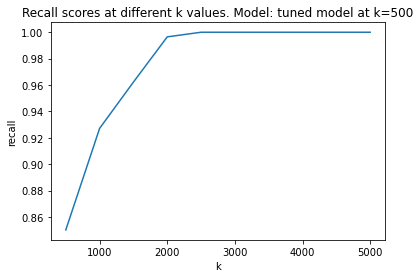

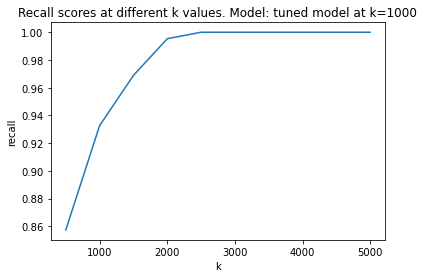

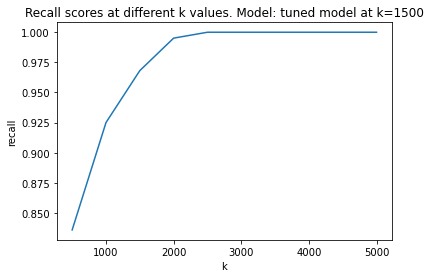

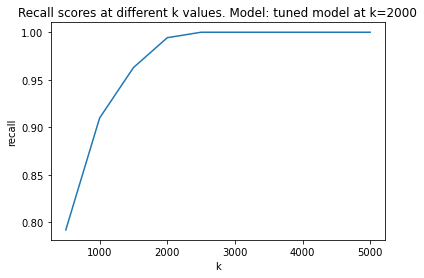

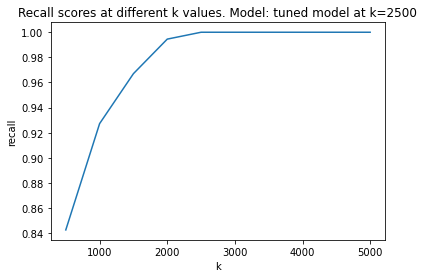

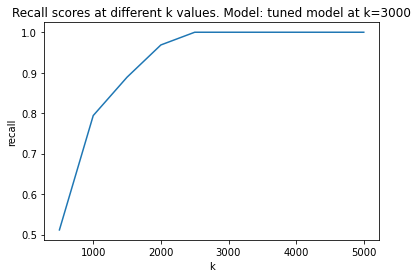

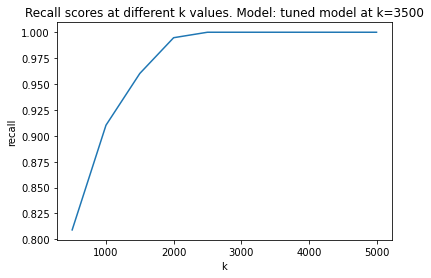

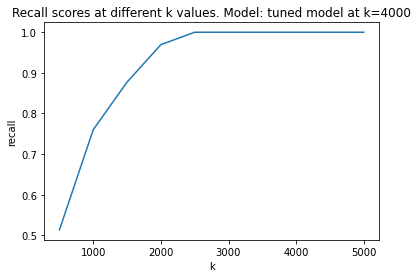

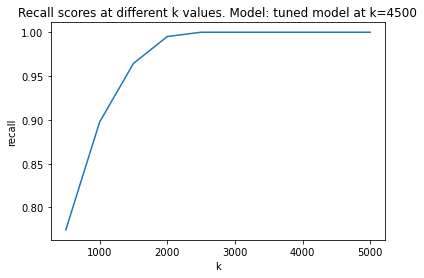

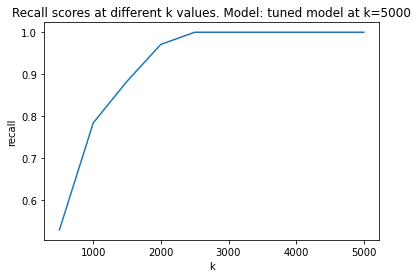

In [39]:
### Best hyperparameters to maximise recall_at_k score

counter = 1
best_average_score_recall = 0
best_hyperparams_recall = None
best_model_recall = None
for k in range(500, 5001, 500):
    (score_recall, hyperparams_recall, model) = max(random_search_recall_at_k(k=k, train=train2, item_features = books_metadata_csr, num_threads=1), key=lambda x: x[0])
    print("\nBest recall score at k={}: {}".format(k, score_recall))
    recall_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its recall score changes as k changes
    for j in range(500, 5001, 500):
        recall_score = recall_at_k(model, validation, train2, k=j, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        recall_score_array.append(recall_score)
    ave_recall_score = sum(recall_score_array) / len(recall_score_array)
    if ave_recall_score > best_average_score_recall:
        best_average_score_recall = ave_recall_score
        best_hyperparams_recall = hyperparams_recall
        best_model_recall = model
    print("Recall scores at k={}: {}".format(k, recall_score_array))
    plt.figure(counter)
    plt.plot(range(500, 5001, 500), recall_score_array)
    plt.xlabel('k')
    plt.ylabel('recall')
    plt.title("Recall scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average recall: {} \nBest hyperparams to maximise recall_at_k score: {}".format(best_average_score_recall, hyperparams_recall))

### Model Evaluation

In [40]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

# Normal Case

In [41]:
users = list(interactions_selected2['user_id'])
random_user = random.choice(users)

### 1. Model that maximises AUC score

In [42]:
AUC_score = auc_score(model, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
precision_k = precision_at_k(model, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(model, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(model, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.7070488 

Precision at k= 5 : 0.002182215 

Recall at k= 500 : 0.5422194180248276 

User: bd9708420694a56d30a3855769067ec6
Known Likes:
1- The Crossover
2- Where the Sidewalk Ends
3- The Divine Comedy
4- The Canterbury Tales
5- Hamlet
6- The Odyssey

 Recommended Items:
1- The Complete English Poems
2- Selected Poems
3- The Canterbury Tales (Barnes & Noble Classics Series)
4- The Odyssey
5- The Canterbury Tales
6- Selected Poems
7- A Kick in the Head: An Everyday Guide to Poetic Forms
8- Rubaiyat of Omar Khayyam
9- 19 Varieties of Gazelle: Poems of the Middle East
10- Black Coffee Blues


### 2. Model that maximises precision_at_k score

In [43]:
AUC_score = auc_score(best_model_precision, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_precision, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_precision, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.86566794 

Precision at k= 5 : 0.028477905 

Recall at k= 500 : 0.8459510558959262 

User: bd9708420694a56d30a3855769067ec6
Known Likes:
1- The Crossover
2- Where the Sidewalk Ends
3- The Divine Comedy
4- The Canterbury Tales
5- Hamlet
6- The Odyssey

 Recommended Items:
1- Poetry and Prose
2- The Book of Disquiet
3- The Complete Sonnets and Poems
4- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
5- Robert Browning's Poetry
6- John Donne's Poetry
7- Leaves of Grass
8- The Portable Dorothy Parker
9- Selected Poems
10- The Complete English Poems


### 3. Model that maximises recall_at_k score

In [44]:
AUC_score = auc_score(best_model_recall, test_interactions, train_interactions, item_features = books_metadata_csr, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_recall, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_recall, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_recall, user_book_interaction, random_user, user_dict, relevant_item_dict)

AUC Score:  0.883869 

Precision at k= 5 : 0.009274414 

Recall at k= 500 : 0.8656179753733376 

User: bd9708420694a56d30a3855769067ec6
Known Likes:
1- The Crossover
2- Where the Sidewalk Ends
3- The Divine Comedy
4- The Canterbury Tales
5- Hamlet
6- The Odyssey

 Recommended Items:
1- The Canterbury Tales
2- The Complete English Poems
3- Selected Poems
4- Poetry and Prose
5- The Canterbury Tales (Barnes & Noble Classics Series)
6- Orlando Furioso
7- The Iliad
8- The Complete Poems of Emily Dickinson
9- Ramayana
10- Robert Browning's Poetry


# Cold start scenario

In [45]:
interactions_selected1 = interactions_selected[interactions_selected['user_id'].isin(random.sample(list(interactions_selected['user_id'].unique()), 
                                                                                                  k=5000))]

user_book_interaction1 = pd.pivot_table(interactions_selected1, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
user_book_interaction1 = user_book_interaction1.fillna(0)

user_book_interaction1.head(10)

user_book_interaction1

book_id,289,290,291,292,484,676,1371,1372,1376,1381,...,35919520,35921170,35991559,36122873,36126998,36153320,36188318,36282926,36286613,36417323
user_id,,,,,,,,,,,,,,,,,,,,,
000aca1cd913ae8ddfa0dd46804488f0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002561280c69b5f2bb20d13f2a8c9c4a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0025bd3b4d083276aa1da29c2bbdef88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00321c623290ac06fe5c63e02b3cbdbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003ae705b1761175a572f1a4e1eb512a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb60b45cc936be87692e0178b3cfcbb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffc04a471db6ced0a661d731f9629b4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffdcb1c27933801046330f847da830d4,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
relevant_book_ids1 = interactions_selected1['book_id'].unique()
relevant_book_ids1

array([    2547, 21561020,     1420, ...,   101306, 17306267, 25330368])

In [47]:
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
    
relevant_item_dict = {}
for i in relevant_book_ids1:
    relevant_item_dict[i] = item_dict[i]

In [48]:
books_metadata_selected_transformed1 = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 'num_pages', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])

books_metadata_selected_transformed1 = books_metadata_selected_transformed1.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed1 = books_metadata_selected_transformed1.loc[books_metadata_selected_transformed1["book_id"].isin(relevant_item_dict)].set_index("book_id")
# books_metadata_selected_transformed = books_metadata_selected_transformed.transpose()
books_metadata_selected_transformed1.head(5)

,average_rating_0.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,is_ebook_0.0,...,"ratings_count_(40.0, 49.0]","ratings_count_(49.0, 59.0]","ratings_count_(59.0, 73.0]","ratings_count_(73.0, 94.0]","ratings_count_(94.0, 125.0]","ratings_count_(125.0, 179.0]","ratings_count_(179.0, 285.0]","ratings_count_(285.0, 614.0]","ratings_count_(614.0, 1029527.0]",language_code_eng
book_id,,,,,,,,,,,,,,,,,,,,,
289,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
290,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
291,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
292,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
484,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [49]:
books_metadata_selected_transformed1.shape

(2942, 211)

In [50]:
books_metadata_csr1 = csr_matrix(books_metadata_selected_transformed1.values)
books_metadata_csr1

<2942x211 sparse matrix of type '<class 'numpy.uint8'>'
	with 17652 stored elements in Compressed Sparse Row format>

In [51]:
user_book_interaction_csr1 = csr_matrix(user_book_interaction1.values)

user_id = list(user_book_interaction1.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

print(len(user_dict))

5000


In [52]:
train_interactions, test_interactions = random_train_test_split(user_book_interaction_csr1, test_percentage=0.2)
train_interactions

<5000x2942 sparse matrix of type '<class 'numpy.float64'>'
	with 8150 stored elements in COOrdinate format>

In [53]:
train2, validation = random_train_test_split(train_interactions, test_percentage=0.2)
train2

<5000x2942 sparse matrix of type '<class 'numpy.float64'>'
	with 6520 stored elements in COOrdinate format>

In [54]:
users = list(interactions_selected1['user_id'])
print(len(users))

21849


In [55]:
def find_known_items_for_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr1))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    return known_items

In [56]:
### Find cold-start user
cold_start_users = []
for user in users:
    known_items = find_known_items_for_user(model, user_book_interaction1, user, user_dict, relevant_item_dict)
    if len(known_items) == 0:
        cold_start_users.append(user)

print(len(cold_start_users))

3704


In [57]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr1))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

### Hyperparameter Tuning

In [58]:
### Best hyperparameters to maximise AUC score
(score_auc, hyperparams_auc, model) = max(random_search_auc(train=train_interactions, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])

print("Best AUC score {} \nHyperparameters: \n{}".format(score_auc, hyperparams_auc))

Best AUC score 0.9003565907478333 
Hyperparameters: 
{'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.08991239659786136, 'item_alpha': 1.4021047784485973e-08, 'user_alpha': 1.829103815164664e-08, 'max_sampled': 14, 'num_epochs': 6}



Best precision score at k=1: 0.049840934574604034
Precision scores at k=1: [0.05882353, 0.03163993, 0.021390375, 0.017825311, 0.014616756, 0.013071896, 0.012477718, 0.011475044, 0.010299069]

Best precision score at k=2: 0.029598308727145195
Precision scores at k=2: [0.056149732, 0.03787879, 0.029411765, 0.02473262, 0.021212121, 0.019310756, 0.018589254, 0.016822638, 0.015349573]

Best precision score at k=3: 0.018808776512742043
Precision scores at k=3: [0.047237076, 0.03698752, 0.026737968, 0.021167558, 0.021212121, 0.019607844, 0.018716577, 0.017045455, 0.015547633]

Best precision score at k=4: 0.02317708358168602
Precision scores at k=4: [0.060606062, 0.030303031, 0.02436126, 0.029411765, 0.02406417, 0.02124183, 0.018843902, 0.01671123, 0.014854427]

Best precision score at k=5: 0.028297875076532364
Precision scores at k=5: [0.13547237, 0.07308378, 0.05496138, 0.041666668, 0.034937613, 0.030154489, 0.025974026, 0.023284314, 0.021291345]

Best precision score at k=6: 0.02078928984

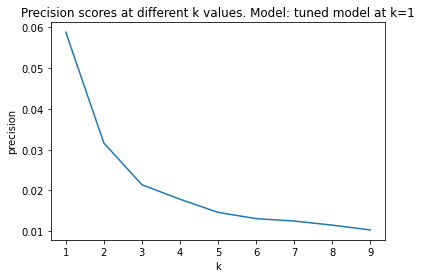

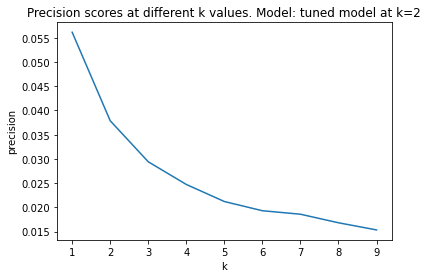

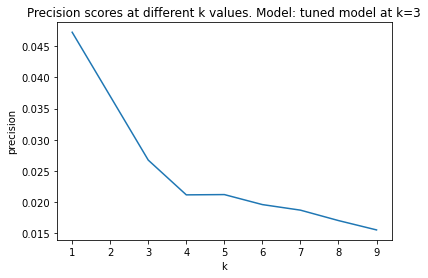

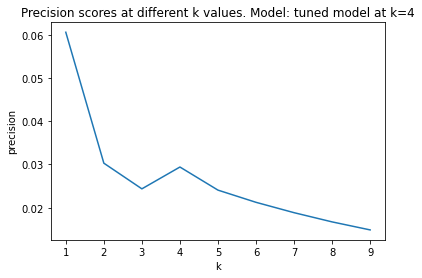

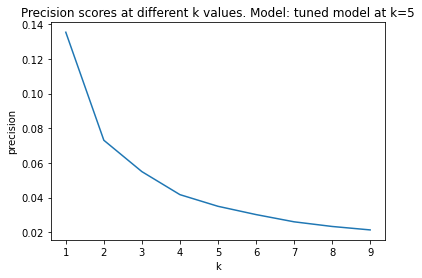

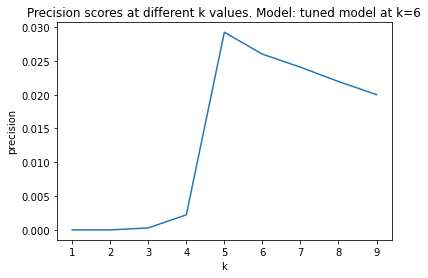

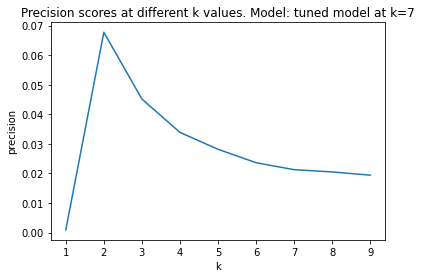

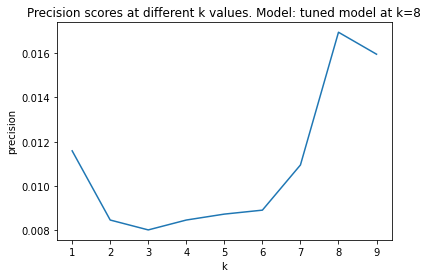

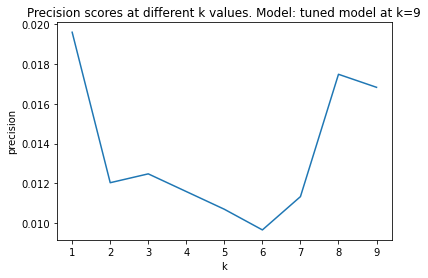

In [59]:
### Best hyperparameters to maximise precision_at_k score

counter = 1
best_average_score_precision = 0
best_hyperparams_precision = None
best_model_precision = None
best_k = 0
for k in range(1, 10):
    (score_precision, hyperparams_precision, model) = max(random_search_precision_at_k(k=k, train=train2, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])
    print("\nBest precision score at k={}: {}".format(k, score_precision))
    precision_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its precision score changes as k changes
    for j in range(1, 10):
        precision_score = precision_at_k(model, validation, train2, k=j, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        precision_score_array.append(precision_score)
    ave_precision_score = sum(precision_score_array) / len(precision_score_array)
    if ave_precision_score > best_average_score_precision:
        best_average_score_precision = ave_precision_score
        best_hyperparams_precision = hyperparams_precision
        best_model_precision = model
        best_k = k
    print("Precision scores at k={}: {}".format(k, precision_score_array))
    plt.figure(counter)
    plt.plot(range(1, 10), precision_score_array)
    plt.xlabel('k')
    plt.ylabel('precision')
    plt.title("Precision scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average precision: {} \nBest k: {} \nBest hyperparams to maximise precision_at_k score: {}".format(best_average_score_precision, best_k, hyperparams_precision))


Best recall score at k=500: 0.8314769856436525
Recall scores at k=500: [0.834863339275104, 0.9066558441558441, 0.9381366182836771, 0.9584893048128342, 0.9811200237670825, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1000: 0.8982786357786356
Recall scores at k=1000: [0.8347243442831679, 0.8998408454290807, 0.9376771920889566, 0.959349800526271, 0.9845811051693403, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=1500: 0.942241646408313
Recall scores at k=1500: [0.7964497920380273, 0.8960911637382225, 0.9387244291656056, 0.9675727866904337, 0.9840909090909091, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2000: 0.9694819819819819
Recall scores at k=2000: [0.7986524912995501, 0.9038876156523216, 0.9433600713012477, 0.9669340463458111, 0.9881164587046941, 1.0, 1.0, 1.0, 1.0, 1.0]

Best recall score at k=2500: 0.987567925067925
Recall scores at k=2500: [0.7837970036499449, 0.8891021560139208, 0.9372676343264578, 0.9604575163398692, 0.9876708259061199, 1.0, 1.0, 1.0, 1.0, 1.0]

Best 

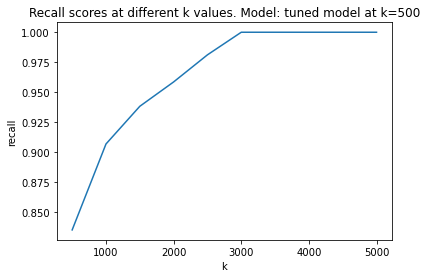

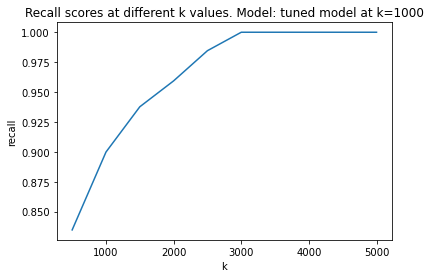

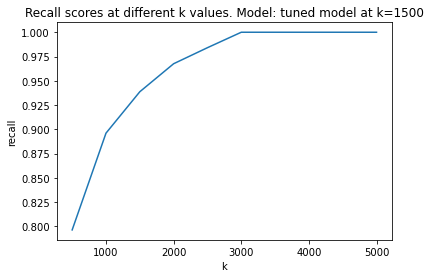

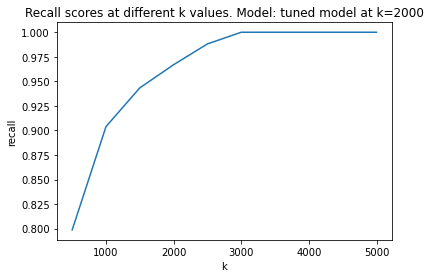

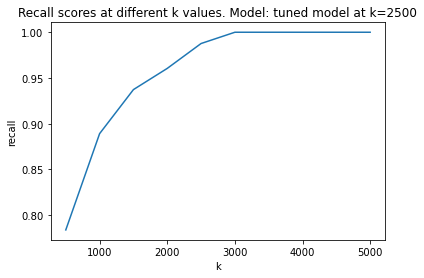

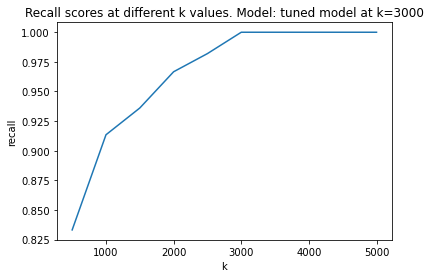

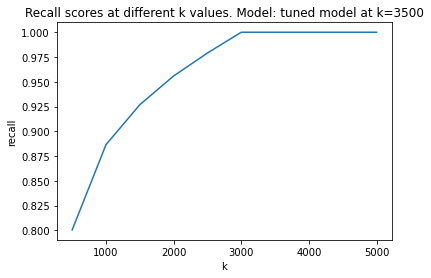

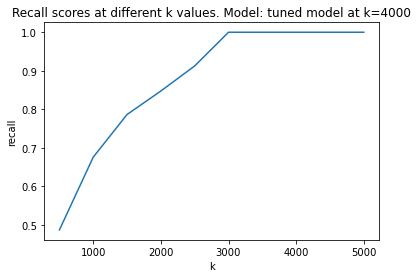

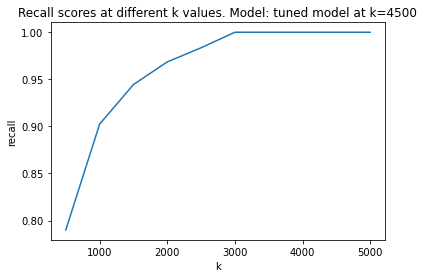

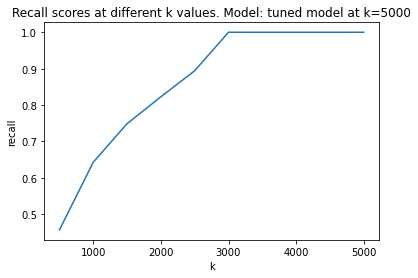

In [60]:
### Best hyperparameters to maximise recall_at_k score

counter = 1
best_average_score_recall = 0
best_hyperparams_recall = None
best_model_recall = None
for k in range(500, 5001, 500):
    (score_recall, hyperparams_recall, model) = max(random_search_recall_at_k(k=k, train=train2, item_features = books_metadata_csr1, num_threads=1), key=lambda x: x[0])
    print("\nBest recall score at k={}: {}".format(k, score_recall))
    recall_score_array = []
    # After getting the best hyperparams for the model at a specific k, we see how its recall score changes as k changes
    for j in range(500, 5001, 500):
        recall_score = recall_at_k(model, validation, train2, k=j, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
        recall_score_array.append(recall_score)
    ave_recall_score = sum(recall_score_array) / len(recall_score_array)
    if ave_recall_score > best_average_score_recall:
        best_average_score_recall = ave_recall_score
        best_hyperparams_recall = hyperparams_recall
        best_model_recall = model
    print("Recall scores at k={}: {}".format(k, recall_score_array))
    plt.figure(counter)
    plt.plot(range(500, 5001, 500), recall_score_array)
    plt.xlabel('k')
    plt.ylabel('recall')
    plt.title("Recall scores at different k values. Model: tuned model at k={}".format(k))
    plt.show
    counter+=1

print("\nBest highest average recall: {} \nBest hyperparams to maximise recall_at_k score: {}".format(best_average_score_recall, hyperparams_recall))

In [61]:
cold_start_user = random.choice(cold_start_users)

### 1. Model that maximises AUC Score

In [62]:
AUC_score = auc_score(model, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
precision_k = precision_at_k(model, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(model, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(model, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.69573843 

Precision at k= 5 : 0.0019519519 

Recall at k= 500 : 0.4836314127980795 

User: fb4420766e4e721ba45c706d3772d70a
Known Likes:

 Recommended Items:
1- Rubaiyat of Omar Khayyam
2- Selected Poems
3- Vile Verses
4- A Kick in the Head: An Everyday Guide to Poetic Forms
5- The Rig Veda
6- Black Coffee Blues
7- Boris Godunov
8- Hamlet
9- Hamlet
10- King Ink


### 2. Model that maximises precision_at_k score

In [63]:
AUC_score = auc_score(best_model_precision, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_precision, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_precision, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.8745766 

Precision at k= 5 : 0.03138138 

Recall at k= 500 : 0.8128893503893504 

User: fb4420766e4e721ba45c706d3772d70a
Known Likes:

 Recommended Items:
1- The Odyssey
2- Poetry and Prose
3- The Canterbury Tales
4- Leaves of Grass
5- John Donne's Poetry
6- Robert Browning's Poetry
7- The Book of Disquiet
8- The Complete Sonnets and Poems
9- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
10- The Complete English Poems


### 3. Model that maximises recall_at_k score

In [64]:
AUC_score = auc_score(best_model_recall, test_interactions, train_interactions, item_features = books_metadata_csr1, num_threads=1).mean()
k = 5
precision_k = precision_at_k(best_model_recall, test_interactions, train_interactions, k=5, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
recall_k = recall_at_k(best_model_recall, test_interactions, train_interactions, k=500, user_features=None, item_features=books_metadata_csr1, preserve_rows=False, num_threads=1, check_intersections=True).mean()
print("AUC Score: ", AUC_score, "\n")
print("Precision at k=", 5, ":", precision_k, "\n")
print("Recall at k=", 500, ":", recall_k, "\n")

sample_recommendation_user(best_model_precision, user_book_interaction1, cold_start_user, user_dict, relevant_item_dict)

AUC Score:  0.8894139 

Precision at k= 5 : 0.0069069066 

Recall at k= 500 : 0.835131235131235 

User: fb4420766e4e721ba45c706d3772d70a
Known Likes:

 Recommended Items:
1- The Odyssey
2- Poetry and Prose
3- The Canterbury Tales
4- Leaves of Grass
5- John Donne's Poetry
6- Robert Browning's Poetry
7- The Book of Disquiet
8- The Complete Sonnets and Poems
9- The Poetry of Robert Frost: The Collected Poems, Complete and Unabridged
10- The Complete English Poems
